In [1]:
#pip install pandas-profiling[notebook,html]

In [2]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import lightgbm as lgb

In [3]:
churn_df = pd.read_csv(r'WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Comenzamos haciendo un analisis exploratorio univariado para detectar outliers, missing values y aspectos particulares de la distribución de cada variable

In [4]:
profile = ProfileReport(churn_df, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile

In [5]:
profile.to_file(r"churn_df_inicial.html")

# Hay 21 variables: 13 categoricas, 6 booleanas y  con 7043 observaciones. Donde la variable target (churn) tiene una tasa de 26.5% (1869/7043)

# Encontramos que hay información repetida en distintas variables como es el caso de la categoría "no internet service", por lo tanto, al momento de contruir variables booleanas tendremos que tenerlo en cuenta para no duplicar información. Y que la variable TOTAL CHARGES esta definida como categorica ya que tiene espacios como valores posibles, sin embargo, es una variable continua.

In [6]:
#Transformación de datos

#Reemplazamos esos espacios con nulos

churn_df['TotalCharges'] = churn_df["TotalCharges"].replace(" ",np.nan)#transformamos TOTAL CHARGES a FLOAT 

#si vuelvo a analizar la variable ahora existen valores nulos en la variable TOTALCHARGES
churn_df.isnull().sum() 

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [7]:
#Eliminamos lo casos nulos 

churn_df = churn_df[churn_df["TotalCharges"].notnull()]
churn_df = churn_df.reset_index()[churn_df.columns]

#convierto la variable a numerica (float)

churn_df["TotalCharges"] = churn_df["TotalCharges"].astype(float)

In [8]:
#Continuación de tranformación de variables

#Ya tenemos la variable si tiene servicio de telefono o no,
#con lo cual podemos reemplazar en la variable MultipeLines la Categoria "No phone service" por "No"

churn_df['MultipleLines']  = churn_df['MultipleLines'].replace({'No phone service' : 'No'})
        

In [9]:
#Ya tenemos en InternetService la respuesta si el cliente no tiene el servicio,
#con lo cual podemos reemplazar en todas las variables donde dice "No internet service" por "No"

replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    churn_df[i]  = churn_df[i].replace({'No internet service' : 'No'})
    

In [10]:
#Si vuelvo a analizar las correlaciones entre las variables aparece una leve correlación entre TotalCharges y MonthlyCharges,
#y una alta correlacion entre tenure y TotalCharges

profile = ProfileReport(churn_df, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile

In [11]:
#Paso a booleanas todas las variables categoricas

#primero todas las que ya son booleanas y tienen valore "yes/no" a 1/0
replace_cols = [ 'Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies','PaperlessBilling','Churn']
for i in replace_cols : 
    churn_df[i]  = np.where(churn_df[i]=='Yes',1,0)

In [12]:
#transformo la variable Gender en 0/1
churn_df['gender']  = np.where(churn_df['gender']=='Female',1,0) 

In [13]:
#las categorias que mejor discriminan el churn seran las creadas
churn_df['DSL']  = np.where(churn_df['InternetService']=='DSL',1,0)
churn_df['NoInternetService']  = np.where(churn_df['InternetService']=='No',1,0)

In [14]:
#las categorias que mejor discriminan el churn seran las creadas

churn_df['OneyearContract']  = np.where(churn_df['Contract']=='One year',1,0)
churn_df['TwoyearContract']  = np.where(churn_df['Contract']=='Two year',1,0)

In [15]:
#transformo la variable InternetService en dos booleanas
#para ver que categorias genero, previamente analizo la tasa de churn para cada una
pd.crosstab(churn_df.InternetService, churn_df.Churn), pd.crosstab(churn_df.InternetService, churn_df.Churn).apply(lambda r: r/r.sum(), axis=1)

(Churn               0     1
 InternetService            
 DSL              1957   459
 Fiber optic      1799  1297
 No               1407   113,
 Churn                   0         1
 InternetService                    
 DSL              0.810017  0.189983
 Fiber optic      0.581072  0.418928
 No               0.925658  0.074342)

In [16]:
#transformo la variable Contract en dos booleanas
#para ver que categorias genero, previamente analizo la tasa de churn para cada una
pd.crosstab(churn_df.Contract, churn_df.Churn), pd.crosstab(churn_df.Contract, churn_df.Churn).apply(lambda r: r/r.sum(), axis=1)

(Churn              0     1
 Contract                  
 Month-to-month  2220  1655
 One year        1306   166
 Two year        1637    48,
 Churn                  0         1
 Contract                          
 Month-to-month  0.572903  0.427097
 One year        0.887228  0.112772
 Two year        0.971513  0.028487)

In [17]:
#transformo la variable PaymentMethod en dos booleanas
#para ver que categorias genero, previamente analizo la tasa de churn para cada una
pd.crosstab(churn_df.PaymentMethod, churn_df.Churn),pd.crosstab(churn_df.PaymentMethod, churn_df.Churn).apply(lambda r: r/r.sum(), axis=1)


(Churn                         0     1
 PaymentMethod                        
 Bank transfer (automatic)  1284   258
 Credit card (automatic)    1289   232
 Electronic check           1294  1071
 Mailed check               1296   308,
 Churn                             0         1
 PaymentMethod                                
 Bank transfer (automatic)  0.832685  0.167315
 Credit card (automatic)    0.847469  0.152531
 Electronic check           0.547146  0.452854
 Mailed check               0.807980  0.192020)

In [18]:
#las categorias que mejor discriminan el churn seran las creadas

churn_df['BanktransferPay']  = np.where(churn_df['PaymentMethod']=='Bank transfer (automatic)',1,0)
churn_df['CreditcardPay']  = np.where(churn_df['PaymentMethod']=='Credit card (automatic)',1,0)
churn_df['MailedcheckPay']  = np.where(churn_df['PaymentMethod']=='Mailed check',1,0)

In [19]:
churn_df['Cant_productos'] = churn_df['PhoneService'] + (1-churn_df['NoInternetService'])
churn_df['Cant_productos_internet'] = churn_df['OnlineSecurity'] + churn_df['OnlineBackup'] + \
                                      churn_df['DeviceProtection'] + churn_df['TechSupport'] + \
                                      churn_df['StreamingTV'] + churn_df['StreamingMovies'] 
churn_df['monthly_sobre_total'] = churn_df['MonthlyCharges'] / churn_df['TotalCharges']

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#import lightgbm as lgb


X_train, X_test, y_train, y_test = train_test_split(churn_df.drop(['customerID','Churn'],axis=1), churn_df[['Churn']], 
                                                    test_size=0.33, random_state=42)

In [21]:
# Con las variables continuas genero derivadas categoricas utilizando los deciles de su distribución.
# para no producir data liquid mantenemos los deciles de train sobre test

#deciles de la variable tenure
[X_train['tenure'].quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9])]

[0.1     2.0
 0.2     6.0
 0.3    12.0
 0.4    20.0
 0.5    29.0
 0.6    39.0
 0.7    51.0
 0.8    61.0
 0.9    69.0
 Name: tenure, dtype: float64]

In [22]:
#reagrupo la variable tenure en base al decil
conditions2 = [
    (X_train['tenure'] <= 2),
    (X_train['tenure'] <= 6),
    (X_train['tenure'] <= 12),
    (X_train['tenure'] <= 20),
    (X_train['tenure'] <= 29),
    (X_train['tenure'] <= 39),
    (X_train['tenure'] <= 51),
    (X_train['tenure'] <= 61),
    (X_train['tenure'] <= 69)]
choices2 = [0,1, 2,3,4,5,6,7,8]
X_train['tenure_d'] = np.select(conditions2, choices2, default=9)

In [23]:
#deciles de la variable TotalCharges
[X_train['TotalCharges'].quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9])]

[0.1      85.50
 0.2     266.80
 0.3     547.80
 0.4     940.35
 0.5    1388.00
 0.6    2036.55
 0.7    3092.00
 0.8    4447.55
 0.9    5969.30
 Name: TotalCharges, dtype: float64]

In [24]:
#reagrupo la variable TotalCharges en base al decil
conditions2 = [
    (X_train['TotalCharges'] <= 85.5),
    (X_train['TotalCharges'] <= 266.8),
    (X_train['TotalCharges'] <= 547.8),
    (X_train['TotalCharges'] <= 940.35),
    (X_train['TotalCharges'] <= 1388),
    (X_train['TotalCharges'] <= 2036.55),
    (X_train['TotalCharges'] <= 3092),
    (X_train['TotalCharges'] <= 4447.55),
    (X_train['TotalCharges'] <= 5969.3)]
choices2 = [0,1, 2,3,4,5,6,7,8]
X_train['TotalCharges_d'] = np.select(conditions2, choices2, default=9)

In [25]:
#deciles de la variable MonthlyCharges
[X_train['MonthlyCharges'].quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9])]

[0.1     20.05
 0.2     25.00
 0.3     45.80
 0.4     58.55
 0.5     70.30
 0.6     79.10
 0.7     85.55
 0.8     94.20
 0.9    102.45
 Name: MonthlyCharges, dtype: float64]

In [26]:
#reagrupo la variable TotalCharges en base al decil
conditions2 = [
    (X_train['MonthlyCharges'] <= 20.05),
    (X_train['MonthlyCharges'] <= 25),
    (X_train['MonthlyCharges'] <= 45.8),
    (X_train['MonthlyCharges'] <= 58.55),
    (X_train['MonthlyCharges'] <= 70.30),
    (X_train['MonthlyCharges'] <= 79.10),
    (X_train['MonthlyCharges'] <= 85.55),
    (X_train['MonthlyCharges'] <= 94.20),
    (X_train['MonthlyCharges'] <= 102.45)]
choices2 = [0,1, 2,3,4,5,6,7,8]
X_train['MonthlyCharges_d'] = np.select(conditions2, choices2, default=9)

In [27]:
#deciles de la variable monthly_sobre_total
[X_train['monthly_sobre_total'].quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9])]

[0.1    0.014472
 0.2    0.016509
 0.3    0.019868
 0.4    0.025507
 0.5    0.035061
 0.6    0.050379
 0.7    0.086017
 0.8    0.171375
 0.9    0.505846
 Name: monthly_sobre_total, dtype: float64]

In [28]:
#reagrupo la variable monthly_sobre_total en base al decil
conditions2 = [
    (X_train['monthly_sobre_total'] <= 0.014472),
    (X_train['monthly_sobre_total'] <= 0.016509),
    (X_train['monthly_sobre_total'] <= 0.019868),
    (X_train['monthly_sobre_total'] <= 0.025507),
    (X_train['monthly_sobre_total'] <= 0.035061),
    (X_train['monthly_sobre_total'] <= 0.050379),
    (X_train['monthly_sobre_total'] <= 0.086017),
    (X_train['monthly_sobre_total'] <= 0.171375),
    (X_train['monthly_sobre_total'] <= 0.505846)]
choices2 = [0,1, 2,3,4,5,6,7,8]
X_train['monthly_sobre_total_d'] = np.select(conditions2, choices2, default=9)

In [29]:
#reagrupo la variable tenure en base al decil
conditions2 = [
    (X_test['tenure'] <= 2),
    (X_test['tenure'] <= 6),
    (X_test['tenure'] <= 12),
    (X_test['tenure'] <= 20),
    (X_test['tenure'] <= 29),
    (X_test['tenure'] <= 39),
    (X_test['tenure'] <= 51),
    (X_test['tenure'] <= 61),
    (X_test['tenure'] <= 69)]
choices2 = [0,1, 2,3,4,5,6,7,8]
X_test['tenure_d'] = np.select(conditions2, choices2, default=9)

In [30]:
#reagrupo la variable TotalCharges en base al decil
conditions2 = [
    (X_test['TotalCharges'] <= 85.5),
    (X_test['TotalCharges'] <= 266.8),
    (X_test['TotalCharges'] <= 547.8),
    (X_test['TotalCharges'] <= 940.35),
    (X_test['TotalCharges'] <= 1388),
    (X_test['TotalCharges'] <= 2036.55),
    (X_test['TotalCharges'] <= 3092),
    (X_test['TotalCharges'] <= 4447.55),
    (X_test['TotalCharges'] <= 5969.3)]
choices2 = [0,1, 2,3,4,5,6,7,8]
X_test['TotalCharges_d'] = np.select(conditions2, choices2, default=9)

In [31]:
#reagrupo la variable TotalCharges en base al decil
conditions2 = [
    (X_test['MonthlyCharges'] <= 20.05),
    (X_test['MonthlyCharges'] <= 25),
    (X_test['MonthlyCharges'] <= 45.8),
    (X_test['MonthlyCharges'] <= 58.55),
    (X_test['MonthlyCharges'] <= 70.30),
    (X_test['MonthlyCharges'] <= 79.10),
    (X_test['MonthlyCharges'] <= 85.55),
    (X_test['MonthlyCharges'] <= 94.20),
    (X_test['MonthlyCharges'] <= 102.45)]
choices2 = [0,1, 2,3,4,5,6,7,8]
X_test['MonthlyCharges_d'] = np.select(conditions2, choices2, default=9)

In [32]:
#reagrupo la variable monthly_sobre_total en base al decil
conditions2 = [
    (X_test['monthly_sobre_total'] <= 0.014472),
    (X_test['monthly_sobre_total'] <= 0.016509),
    (X_test['monthly_sobre_total'] <= 0.019868),
    (X_test['monthly_sobre_total'] <= 0.025507),
    (X_test['monthly_sobre_total'] <= 0.035061),
    (X_test['monthly_sobre_total'] <= 0.050379),
    (X_test['monthly_sobre_total'] <= 0.086017),
    (X_test['monthly_sobre_total'] <= 0.171375),
    (X_test['monthly_sobre_total'] <= 0.505846)]
choices2 = [0,1, 2,3,4,5,6,7,8]
X_test['monthly_sobre_total_d'] = np.select(conditions2, choices2, default=9)

In [33]:
#Normalizando variables continuas: tenure,MonthlyCharges,TotalCharges,monthly_sobre_total
from sklearn import preprocessing

x = X_train['tenure'].values.reshape(-1, 1) #returns a numpy array
std_scaler_tenure = preprocessing.StandardScaler()
x_scaled = std_scaler_tenure.fit_transform(x)
X_train['tenure_n'] = x_scaled

x = X_train['MonthlyCharges'].values.reshape(-1, 1) #returns a numpy array
std_scaler_MonthlyCharges = preprocessing.StandardScaler()
x_scaled = std_scaler_MonthlyCharges.fit_transform(x)
X_train['MonthlyCharges_n'] = x_scaled

x = X_train['TotalCharges'].values.reshape(-1, 1) #returns a numpy array
std_scaler_TotalCharges = preprocessing.StandardScaler()
x_scaled = std_scaler_TotalCharges.fit_transform(x)
X_train['TotalCharges_n'] = x_scaled

x = X_train['monthly_sobre_total'].values.reshape(-1, 1) #returns a numpy array
std_scaler_monthly_sobre_total = preprocessing.StandardScaler()
x_scaled = std_scaler_monthly_sobre_total.fit_transform(x)
X_train['monthly_sobre_total_n'] = x_scaled

x = X_test['tenure'].values.reshape(-1, 1) #returns a numpy array
x_scaled = std_scaler_tenure.transform(x)
X_test['tenure_n'] = x_scaled

x = X_test['MonthlyCharges'].values.reshape(-1, 1) #returns a numpy array
x_scaled = std_scaler_MonthlyCharges.transform(x)
X_test['MonthlyCharges_n'] = x_scaled

x = X_test['TotalCharges'].values.reshape(-1, 1) #returns a numpy array
x_scaled = std_scaler_TotalCharges.transform(x)
X_test['TotalCharges_n'] = x_scaled

x = X_test['monthly_sobre_total'].values.reshape(-1, 1) #returns a numpy array
x_scaled = std_scaler_monthly_sobre_total.transform(x)
X_test['monthly_sobre_total_n'] = x_scaled
 
x = X_train['Cant_productos'].values.reshape(-1, 1) #returns a numpy array
std_scaler_Cant_productos = preprocessing.StandardScaler()
x_scaled = std_scaler_Cant_productos.fit_transform(x)
X_train['Cant_productos_n'] = x_scaled

x = X_train['Cant_productos_internet'].values.reshape(-1, 1) #returns a numpy array
std_scaler_Cant_productos_internet = preprocessing.StandardScaler()
x_scaled = std_scaler_Cant_productos_internet.fit_transform(x)
X_train['Cant_productos_internet_n'] = x_scaled

x = X_test['Cant_productos'].values.reshape(-1, 1) #returns a numpy array
x_scaled = std_scaler_Cant_productos.transform(x)
X_test['Cant_productos_n'] = x_scaled

x = X_test['Cant_productos_internet'].values.reshape(-1, 1) #returns a numpy array
x_scaled = std_scaler_Cant_productos_internet.transform(x)
X_test['Cant_productos_internet_n'] = x_scaled

In [34]:
#Analisis bivariado sobre training

df_original = X_train.copy()
df_original['Churn'] = y_train.copy()

#genero lista de variables categoricas
cols_nof=X_test.select_dtypes(include=None, exclude=float)
cols_nof=cols_nof.drop(['tenure','DSL','NoInternetService','OneyearContract','TwoyearContract','BanktransferPay'\
                        ,'CreditcardPay','MailedcheckPay'], axis=1) 
cols=cols_nof.columns
#cantidad de variables a revisar
cols_nof.shape

(2321, 22)

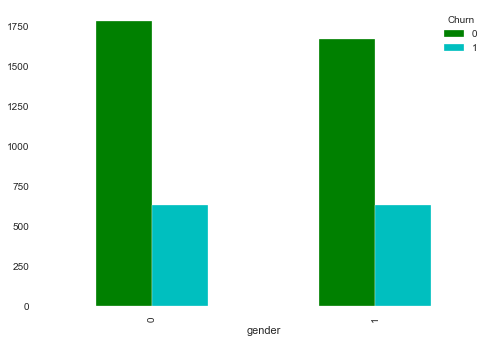

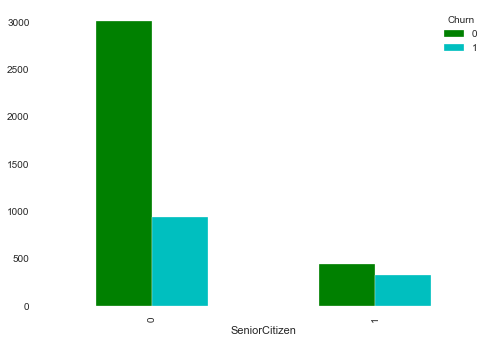

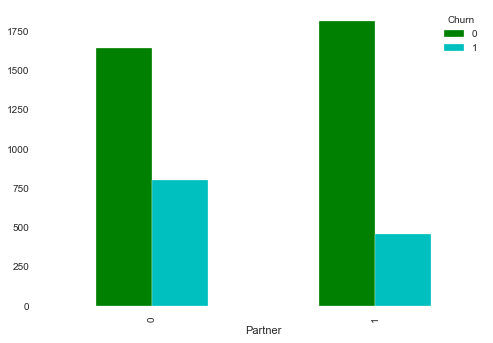

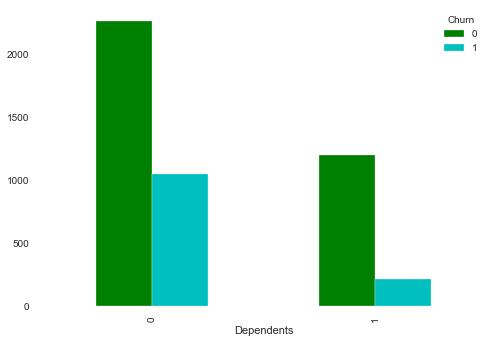

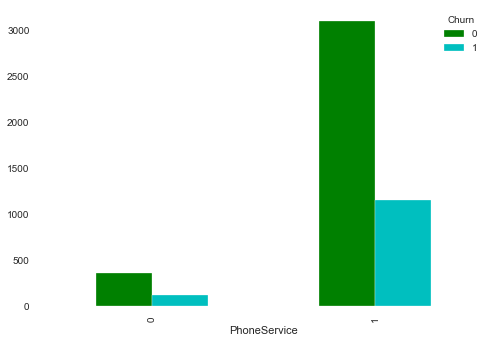

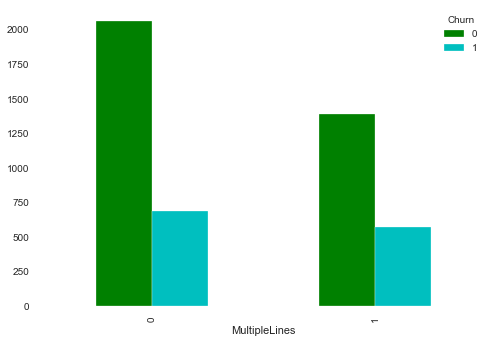

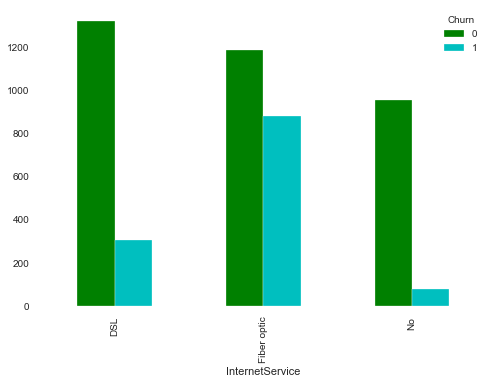

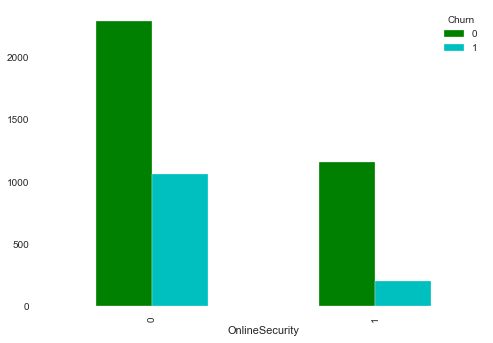

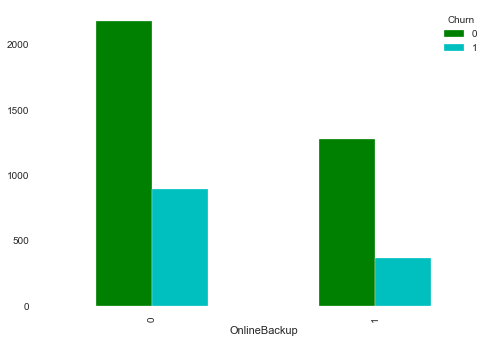

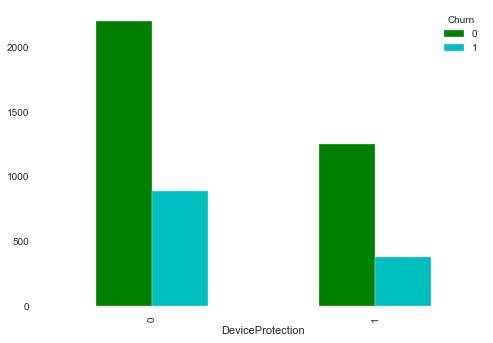

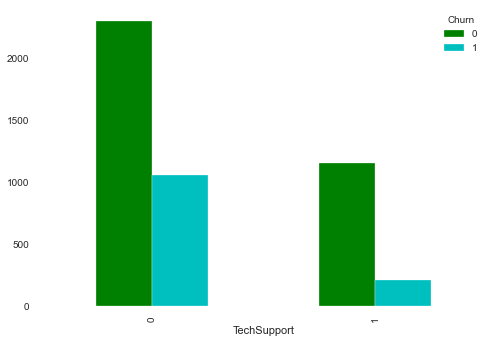

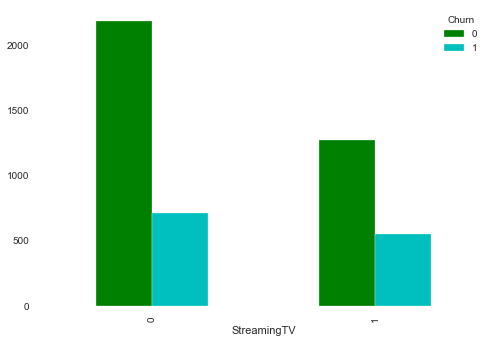

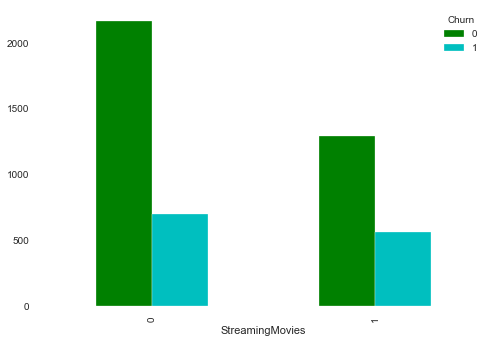

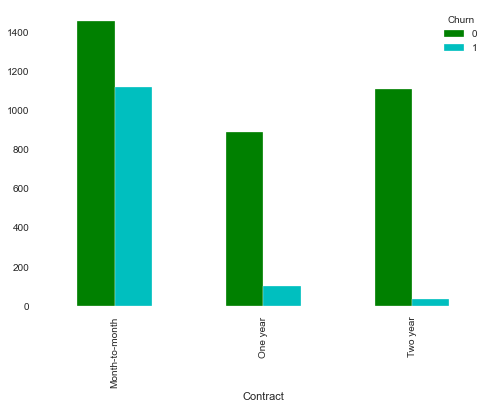

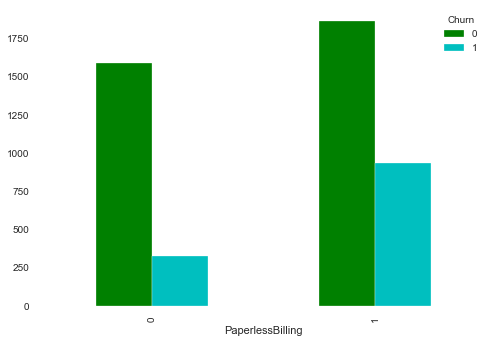

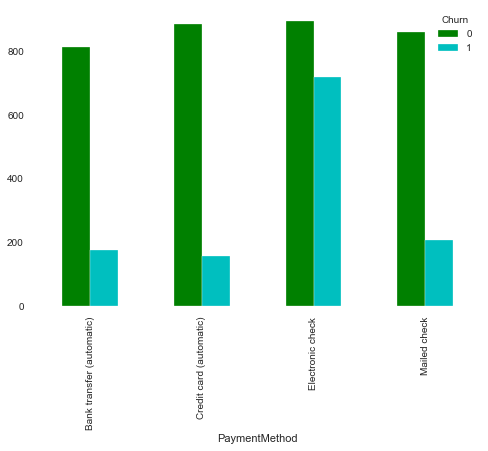

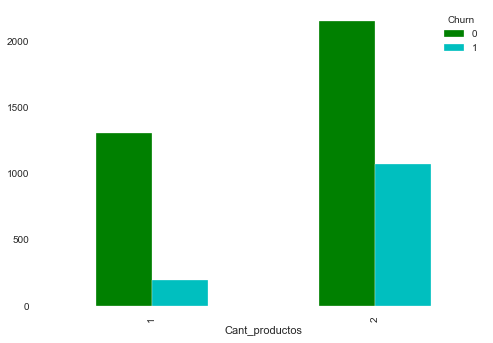

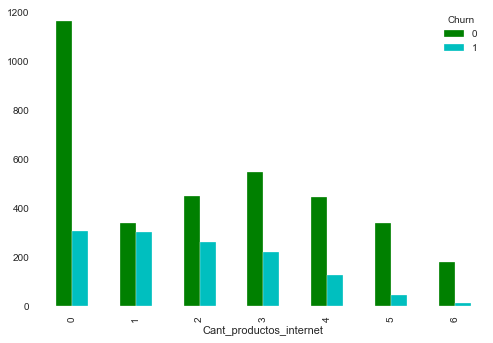

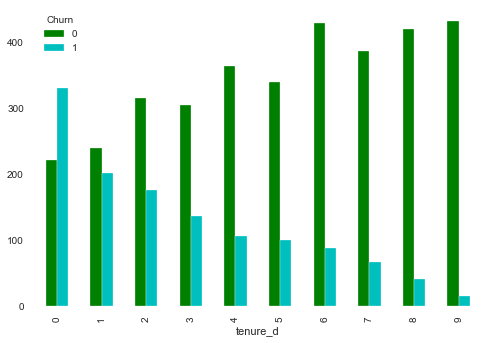

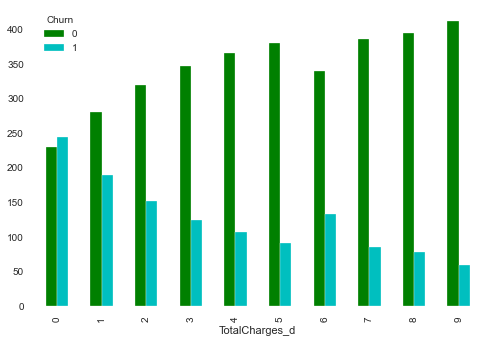

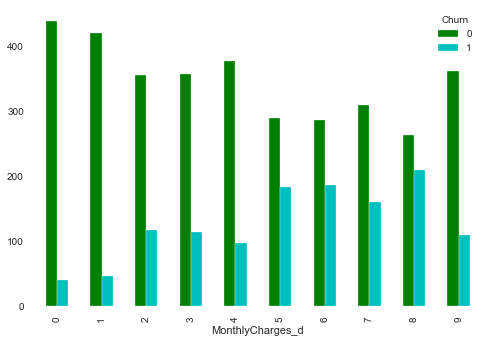

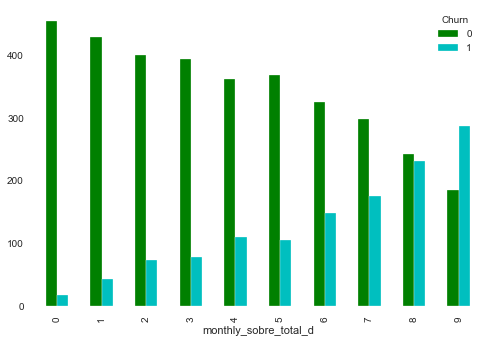

In [35]:
#Analisis bivariado sobre variables categoricas
for i in range(0,22) : 
    df_original.groupby([cols[i],'Churn']).size().unstack().plot(kind='bar',stacked=False,color='g' 'c')

In [36]:
#genero el valor del logaritmo de la tasa de churn para poder comparar con la tasa de las categorias de cada una de las variables
aux=pd.pivot_table(df_original,aggfunc='count',columns='Churn',values='tenure_d')
aux["Total"]=aux[0]+aux[1]
aux["Ratio"]=aux[1]/aux['Total']
aux["log_ratio_gral"]=np.log(aux['Ratio'])
aux=aux.drop(['Total','Ratio',0,1],axis=1)
aux['aux'] = '1'
print(aux)
aux.columns

Churn     log_ratio_gral aux
tenure_d       -1.319582   1


Index(['log_ratio_gral', 'aux'], dtype='object', name='Churn')

In [37]:
#tenure
#armo las tablas para calcular los woe (ln(event/total))
aux_tenure=pd.pivot_table(df_original,index=['tenure_d'],aggfunc='count',columns='Churn',values='tenure')
aux_tenure["Total"]=aux_tenure[0]+aux_tenure[1]
aux_tenure["Ratio"]=aux_tenure[1]/aux_tenure['Total']
aux_tenure["log_ratio"]=np.log(aux_tenure['Ratio'])
aux_tenure['aux'] = '1'

#merge con la tabla auxiliar
aux_tenure2 = pd.merge(aux_tenure,aux, on='aux', how='left')
aux_tenure2['woe']=aux_tenure2["log_ratio"]/aux_tenure2['log_ratio_gral']
print(aux_tenure2)


Churn    0    1  Total     Ratio  log_ratio aux  log_ratio_gral       woe
0      221  330    551  0.598911  -0.512642   1       -1.319582  0.388488
1      239  202    441  0.458050  -0.780777   1       -1.319582  0.591685
2      315  176    491  0.358452  -1.025960   1       -1.319582  0.777488
3      305  136    441  0.308390  -1.176390   1       -1.319582  0.891487
4      364  106    470  0.225532  -1.489294   1       -1.319582  1.128610
5      340   99    439  0.225513  -1.489380   1       -1.319582  1.128675
6      429   87    516  0.168605  -1.780199   1       -1.319582  1.349062
7      387   67    454  0.147577  -1.913405   1       -1.319582  1.450008
8      420   41    461  0.088937  -2.419826   1       -1.319582  1.833782
9      432   15    447  0.033557  -3.394508   1       -1.319582  2.572411


In [38]:
#reagrupo la variable tenure en base al woe
conditions1 = [
    (df_original['tenure_d'] == 0),
    (df_original['tenure_d'] == 1),
    (df_original['tenure_d'] == 2),
    (df_original['tenure_d'] == 3),
    (df_original['tenure_d'] >= 4)  & (df_original['tenure_d'] <= 5),
    (df_original['tenure_d'] >= 6) & (df_original['tenure_d'] <= 7),
    (df_original['tenure_d'] == 8),
    (df_original['tenure_d'] == 9)]
choices1 = [0, 1, 2,3,4,5,6,7]
df_original['tenure_d2'] = np.select(conditions1, choices1, default=0)

In [39]:
#reagrupo la variable tenure en base al woe
conditions1 = [
    (X_test['tenure_d'] == 0),
    (X_test['tenure_d'] == 1),
    (X_test['tenure_d'] == 2),
    (X_test['tenure_d'] == 3),
    (X_test['tenure_d'] >= 4)  & (X_test['tenure_d'] <= 5),
    (X_test['tenure_d'] >= 6) & (X_test['tenure_d'] <= 7),
    (X_test['tenure_d'] == 8),
    (X_test['tenure_d'] == 9)]
choices1 = [0, 1, 2,3,4,5,6,7]
X_test['tenure_d2'] = np.select(conditions1, choices1, default=0)

In [40]:
#MonthlyCharges
#armo las tablas para calcular los woe (ln(event/total))
aux_mc=pd.pivot_table(df_original,index=['MonthlyCharges_d'],aggfunc='count',columns='Churn',values='MonthlyCharges')
aux_mc["Total"]=aux_mc[0]+aux_mc[1]
aux_mc["Ratio"]=aux_mc[1]/aux_mc['Total']
aux_mc["log_ratio"]=np.log(aux_mc['Ratio'])
aux_mc['aux'] = '1'

#merge con la tabla auxiliar
aux_mc2 = pd.merge(aux_mc,aux, on='aux', how='left')
aux_mc2['woe']=aux_mc2["log_ratio"]/aux_mc2['log_ratio_gral']
print(aux_mc2)


Churn    0    1  Total     Ratio  log_ratio aux  log_ratio_gral       woe
0      438   40    478  0.083682  -2.480731   1       -1.319582  1.879937
1      420   46    466  0.098712  -2.315544   1       -1.319582  1.754755
2      355  116    471  0.246285  -1.401268   1       -1.319582  1.061903
3      356  114    470  0.242553  -1.416534   1       -1.319582  1.073472
4      376   96    472  0.203390  -1.592631   1       -1.319582  1.206920
5      289  183    472  0.387712  -0.947493   1       -1.319582  0.718025
6      285  186    471  0.394904  -0.929111   1       -1.319582  0.704095
7      309  160    469  0.341151  -1.075429   1       -1.319582  0.814977
8      263  209    472  0.442797  -0.814645   1       -1.319582  0.617350
9      361  109    470  0.231915  -1.461385   1       -1.319582  1.107460


In [41]:
#reagrupo la variable MonthlyCharges_d en base al woe
conditions3 = [
    (df_original['MonthlyCharges_d'] <2),
    (df_original['MonthlyCharges_d'] >= 2) & (df_original['MonthlyCharges_d'] <5 ),
    (df_original['MonthlyCharges_d'] >= 5) & (df_original['MonthlyCharges_d'] <9 ),
    (df_original['MonthlyCharges_d'] == 9)                                        ]
choices3 = [0, 1, 2,1]
df_original['MonthlyCharges_d2'] = np.select(conditions3, choices3, default=0)

In [42]:
#reagrupo la variable MonthlyCharges_d en base al woe
conditions3 = [
    (X_test['MonthlyCharges_d'] <2),
    (X_test['MonthlyCharges_d'] >= 2) & (X_test['MonthlyCharges_d'] <5 ),
    (X_test['MonthlyCharges_d'] >= 5) & (X_test['MonthlyCharges_d'] <9 ),
    (X_test['MonthlyCharges_d'] == 9)                                        ]
choices3 = [0, 1, 2,1]
X_test['MonthlyCharges_d2'] = np.select(conditions3, choices3, default=0)
print(X_test)

      gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
2476       0              1        1           0      61             1   
6773       1              0        0           0      19             1   
6116       0              0        1           0      13             1   
3047       0              0        1           0      37             1   
4092       1              0        0           0       6             0   
...      ...            ...      ...         ...     ...           ...   
1114       1              0        1           1      48             1   
4949       0              0        0           0      13             1   
298        0              0        1           1      40             1   
3307       0              0        0           0       1             1   
5576       0              0        0           0       1             1   

      MultipleLines InternetService  OnlineSecurity  OnlineBackup  ...  \
2476              1              No  

In [43]:
#TotalCharges_d
#armo las tablas para calcular los woe (ln(event/total))
aux_tc=pd.pivot_table(df_original,index=['TotalCharges_d'],aggfunc='count',columns='Churn',values='TotalCharges')
aux_tc["Total"]=aux_tc[0]+aux_tc[1]
aux_tc["Ratio"]=aux_tc[1]/aux_tc['Total']
aux_tc["log_ratio"]=np.log(aux_tc['Ratio'])
aux_tc['aux'] = '1'

#merge con la tabla auxiliar
aux_mt2 = pd.merge(aux_tc,aux, on='aux', how='left')
aux_mt2['woe']=aux_mt2["log_ratio"]/aux_mt2['log_ratio_gral']
print(aux_mc2)


Churn    0    1  Total     Ratio  log_ratio aux  log_ratio_gral       woe
0      438   40    478  0.083682  -2.480731   1       -1.319582  1.879937
1      420   46    466  0.098712  -2.315544   1       -1.319582  1.754755
2      355  116    471  0.246285  -1.401268   1       -1.319582  1.061903
3      356  114    470  0.242553  -1.416534   1       -1.319582  1.073472
4      376   96    472  0.203390  -1.592631   1       -1.319582  1.206920
5      289  183    472  0.387712  -0.947493   1       -1.319582  0.718025
6      285  186    471  0.394904  -0.929111   1       -1.319582  0.704095
7      309  160    469  0.341151  -1.075429   1       -1.319582  0.814977
8      263  209    472  0.442797  -0.814645   1       -1.319582  0.617350
9      361  109    470  0.231915  -1.461385   1       -1.319582  1.107460


In [44]:
#reagrupo la variable TotalCharges_d en base al woe
conditions2 = [
    (df_original['TotalCharges_d'] == 0),
    (df_original['TotalCharges_d'] == 1),
    (df_original['TotalCharges_d'] == 2),
    (df_original['TotalCharges_d'] == 3),
    (df_original['TotalCharges_d'] >= 4)  & (df_original['TotalCharges_d'] <= 5),
    (df_original['TotalCharges_d'] == 6),
    (df_original['TotalCharges_d'] >= 7) & (df_original['TotalCharges_d'] <= 8),
    (df_original['TotalCharges_d'] == 9)]
choices2 = [0, 1, 2,3,4,5,6,7]
df_original['TotalCharges_d2'] = np.select(conditions2, choices2, default=0)

In [45]:

#reagrupo la variable TotalCharges_d en base al woe
conditions2 = [
    (X_test['TotalCharges_d'] == 0),
    (X_test['TotalCharges_d'] == 1),
    (X_test['TotalCharges_d'] == 2),
    (X_test['TotalCharges_d'] == 3),
    (X_test['TotalCharges_d'] >= 4)  & (X_test['TotalCharges_d'] <= 5),
    (X_test['TotalCharges_d'] == 6),
    (X_test['TotalCharges_d'] >= 7) & (X_test['TotalCharges_d'] <= 8),
    (X_test['TotalCharges_d'] == 9)]
choices2 = [0, 1, 2,3,4,5,6,7]
X_test['TotalCharges_d2'] = np.select(conditions2, choices2, default=0)

In [46]:
#arma la estructura de dummies en base a las variables reclasificadas 
df_original = pd.get_dummies(df_original, columns=['MonthlyCharges_d2'])

In [47]:
X_test = pd.get_dummies(X_test, columns=['MonthlyCharges_d2'])

In [48]:
df_original = pd.get_dummies(df_original, columns=['TotalCharges_d2'])

In [49]:
X_test = pd.get_dummies(X_test, columns=['TotalCharges_d2'])

In [50]:
df_original = pd.get_dummies(df_original, columns=['tenure_d2'])

In [51]:
X_test = pd.get_dummies(X_test, columns=['tenure_d2'])

In [52]:
X_train = df_original.drop(['Churn','InternetService','Contract','PaymentMethod'],axis=1)
X_test = X_test.drop(['InternetService','Contract','PaymentMethod'],axis=1)

In [53]:
X_train = X_train.drop(['tenure', 'MonthlyCharges', 'TotalCharges', 'monthly_sobre_total', 
                        'tenure_d', 'TotalCharges_d', 'MonthlyCharges_d', 'monthly_sobre_total_d',
                        'Cant_productos', 'Cant_productos_internet'], axis=1)
X_test = X_test.drop(['tenure', 'MonthlyCharges', 'TotalCharges', 'monthly_sobre_total', 
                        'tenure_d', 'TotalCharges_d', 'MonthlyCharges_d', 'monthly_sobre_total_d',
                        'Cant_productos', 'Cant_productos_internet'], axis=1)

Accuracy en train 0.83
Accuracy en test 0.8


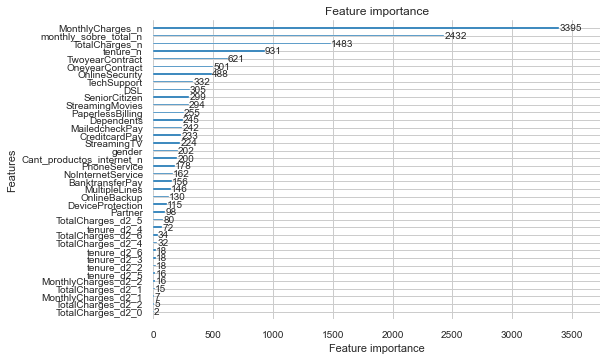

In [54]:
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, free_raw_data=False)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 15,
    'learning_rate': 0.005,
    'verbose_eval': -1
}
num_train, num_feature = X_train.shape
# generate feature names
feature_name = [str(col) for col in X_train.columns]
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_train,  # eval training data
                feature_name=feature_name,
                verbose_eval=False)

y_pred_train = gbm.predict(X_train)
y_pred_test = gbm.predict(X_test)

print("Accuracy en train", accuracy_score(y_train, y_pred_train.round()).round(2))
print("Accuracy en test", accuracy_score(y_test, y_pred_test.round()).round(2))
lgb.plot_importance(gbm)

In [55]:
# fit a model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
treeclf = DecisionTreeClassifier(max_depth=3, criterion='gini')
treeclf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [56]:
y_pred_train = treeclf.predict(X_train)
y_pred_test = treeclf.predict(X_test)

from sklearn.metrics import accuracy_score
print('Accuracy en train:', accuracy_score(y_train, y_pred_train).round(2))
print('Accuracy en test:', accuracy_score(y_test, y_pred_test).round(2))

Accuracy en train: 0.79
Accuracy en test: 0.78


# Exporting data to pickle

In [57]:
import pickle
tuple_objects = (X_train, y_train, X_test, y_test)

# Save tuple
pickle.dump(tuple_objects, open("desafio_1_data.pkl", 'wb'))